# Credit Card Fraud Detection Using KMEANS

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np

/home/alvaro/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


## Auxiliary functions

In [4]:
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

In [5]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## 1. Reading the dataset

In [6]:
df = pd.read_csv("../datasets/CreditCardFraud/creditcard.csv")

## 2. Information preview

In [7]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [8]:
print("Number of features:", len(df.columns))
print("Data set length:", len(df))

Number of features: 31
Data set length: 284807


In [9]:
# 492 fraudulent transactions, 284315 legitimate transactions
# The dataset is unbalanced
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
# Visualization of the types of each of the attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# Check if any column has null values
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


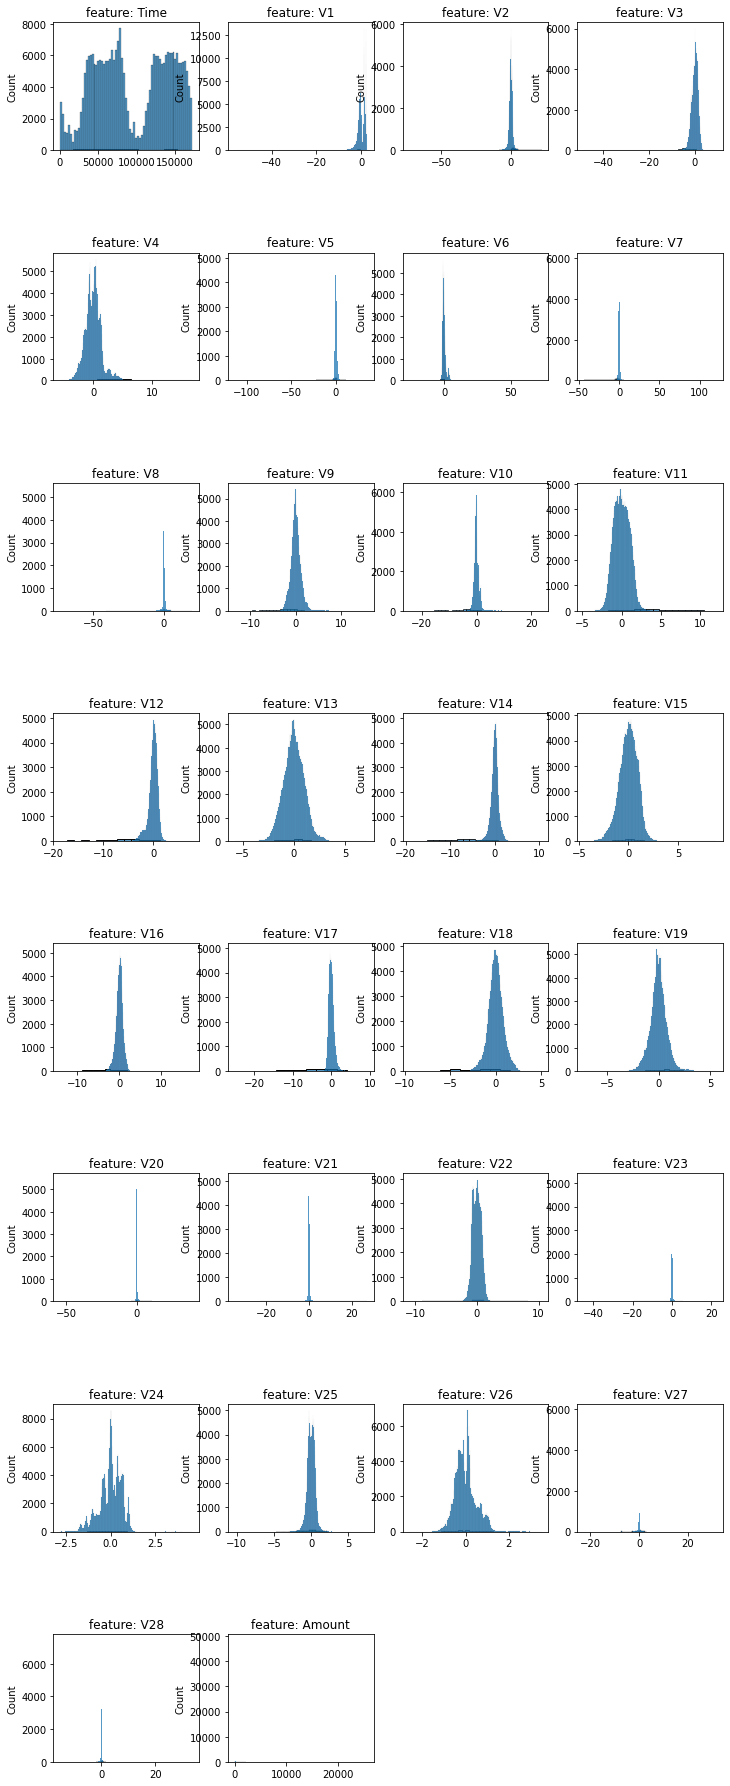

In [13]:
# Graphic representation of the characteristics
features = df.drop("Class", axis=1)

plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(df[f][df["Class"] == 1])
    sns.histplot(df[f][df["Class"] == 0])
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

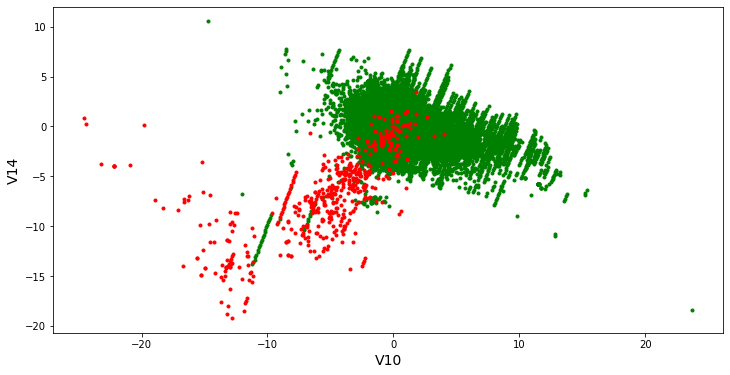

In [14]:
# Graphic representation of two characteristics
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()